<a href="https://colab.research.google.com/github/AtaruOhto/google-colab-sandbox/blob/master/lightbgm_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Zipファイルをダウンロード
import os

bank_zip_file = "./bank.zip"

if not os.path.exists(bank_zip_file):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip


--2020-08-15 11:49:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K   871KB/s    in 0.6s    

2020-08-15 11:49:43 (871 KB/s) - ‘bank.zip’ saved [579043/579043]



In [3]:
# ダウンロードした ZipFileを解凍
import zipfile
extract_dest_dir = "./data"

if not os.path.exists(extract_dest_dir):
  with zipfile.ZipFile(bank_zip_file) as zip:
    zip.extractall(extract_dest_dir)

In [2]:
# データ構造を表示
import pandas as pd

original = pd.read_csv("./train.csv")
original.head()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [3]:
# データ前処理 (欠損値の確認)

print(original.isnull())

print(original.isnull().sum())

original.info()

          id    age    job  marital  ...  pdays  previous  poutcome      y
0      False  False  False    False  ...  False     False     False  False
1      False  False  False    False  ...  False     False     False  False
2      False  False  False    False  ...  False     False     False  False
3      False  False  False    False  ...  False     False     False  False
4      False  False  False    False  ...  False     False     False  False
...      ...    ...    ...      ...  ...    ...       ...       ...    ...
27095  False  False  False    False  ...  False     False     False  False
27096  False  False  False    False  ...  False     False     False  False
27097  False  False  False    False  ...  False     False     False  False
27098  False  False  False    False  ...  False     False     False  False
27099  False  False  False    False  ...  False     False     False  False

[27100 rows x 18 columns]
id           0
age          0
job          0
marital      0
education    

In [4]:
# オリジナルを保存しておく。コピーでオリジナルのデータフレームをメモリ上に退避させておく

df = original.copy()
df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,27095,37,blue-collar,married,secondary,no,26661,yes,no,cellular,27,may,345,4,425,0,unknown,0
27096,27096,35,services,married,secondary,no,42150,yes,no,cellular,27,may,121,1,719,0,unknown,0
27097,27097,35,services,married,unknown,no,34531,no,no,cellular,28,jun,177,2,121,0,unknown,0
27098,27098,30,admin.,single,secondary,no,99621,yes,no,cellular,27,may,121,1,100,0,unknown,0


In [6]:
# One Hot Encoding
df = pd.get_dummies(original, drop_first=True, columns=[ "poutcome", "marital", "education"])

del df["id"]
del df["job"]
del df["contact"]
df

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,poutcome_other,poutcome_success,poutcome_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,31,no,12294,yes,no,21,nov,101,3,498,0,0,1,0,0,1,0,1,0,0
1,29,no,43027,no,no,22,aug,158,2,702,0,1,0,0,1,0,1,0,1,0
2,35,no,12252,yes,no,11,nov,351,1,826,0,0,0,0,0,1,0,0,1,0
3,31,no,99121,yes,yes,16,may,658,2,120,0,0,0,0,0,1,0,1,0,0
4,48,no,42005,yes,no,3,apr,177,1,273,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,no,26661,yes,no,27,may,345,4,425,0,0,0,0,1,1,0,1,0,0
27096,35,no,42150,yes,no,27,may,121,1,719,0,0,0,0,1,1,0,1,0,0
27097,35,no,34531,no,no,28,jun,177,2,121,0,0,0,0,1,1,0,0,0,1
27098,30,no,99621,yes,no,27,may,121,1,100,0,0,0,0,1,0,1,1,0,0


In [7]:
# [yes, no] を [1, 0]に変換
def zero2one(column):
  return column.map({"yes": 1, "no": 0})

df["default"] = zero2one(original["default"])
df["housing"] = zero2one(original["housing"])
df["loan"] = zero2one(original["loan"])
# df["y"] = zero2one(original["y"])

In [8]:
# 月を数値に変換
df["month"] = original["month"].map({"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12})


In [9]:
df

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,poutcome_other,poutcome_success,poutcome_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,31,0,12294,1,0,21,11,101,3,498,0,0,1,0,0,1,0,1,0,0
1,29,0,43027,0,0,22,8,158,2,702,0,1,0,0,1,0,1,0,1,0
2,35,0,12252,1,0,11,11,351,1,826,0,0,0,0,0,1,0,0,1,0
3,31,0,99121,1,1,16,5,658,2,120,0,0,0,0,0,1,0,1,0,0
4,48,0,42005,1,0,3,4,177,1,273,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,0,26661,1,0,27,5,345,4,425,0,0,0,0,1,1,0,1,0,0
27096,35,0,42150,1,0,27,5,121,1,719,0,0,0,0,1,1,0,1,0,0
27097,35,0,34531,0,0,28,6,177,2,121,0,0,0,0,1,1,0,0,0,1
27098,30,0,99621,1,0,27,5,121,1,100,0,0,0,0,1,0,1,1,0,0


In [10]:
y = df["y"]
X = df.drop("y", axis=1)

In [11]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# params = {
#     'gamma': [0.1, 0.2],
#     "eta": [0.1, 0.2, 0.3],
#     "n_estimators": [10, 100],
#     "max_depth": [2, 4, 6, 8],
#     "nthread": [2],
#     "num_leaves": [21, 24, 27 ,31],
#     "min_data_in_leaf":[10, 20, 30]
# }

params = {
    'gamma': [0, 0.1],
    "eta": [0.05, 0.1],
    "n_estimators": [300, 400],
    "max_depth": [2, 3, 4, 5],
    "nthread": [2],
    "num_leaves": [11, 15, 21, 31,41],
    "min_data_in_leaf":[20, 30, 40, 50]
}

# {'eta': 0.1, 'gamma': 0.1, 'max_depth': 2, 'min_data_in_leaf': 30, 'n_estimators': 300, 'nthread': 2, 'num_leaves': 21}


model = lgb.LGBMClassifier()
 
 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clf = GridSearchCV(estimator=model, param_grid=params,   
                    cv=skf, scoring="roc_auc", n_jobs=1, verbose=3)  
clf.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[CV] eta=0.05, gamma=0, max_depth=2, min_data_in_leaf=20, n_estimators=300, nthread=2, num_leaves=11 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  eta=0.05, gamma=0, max_depth=2, min_data_in_leaf=20, n_estimators=300, nthread=2, num_leaves=11, score=0.841, total=   0.2s
[CV] eta=0.05, gamma=0, max_depth=2, min_data_in_leaf=20, n_estimators=300, nthread=2, num_leaves=11 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  eta=0.05, gamma=0, max_depth=2, min_data_in_leaf=20, n_estimators=300, nthread=2, num_leaves=11, score=0.846, total=   0.2s
[CV] eta=0.05, gamma=0, max_depth=2, min_data_in_leaf=20, n_estimators=300, nthread=2, num_leaves=11 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


ストリーミング出力は最後の 5000 行に切り捨てられました。
[CV]  eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11, score=0.828, total=   0.4s
[CV] eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11 
[CV]  eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11, score=0.841, total=   0.4s
[CV] eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11 
[CV]  eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11, score=0.817, total=   0.3s
[CV] eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11 
[CV]  eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11, score=0.859, total=   0.3s
[CV] eta=0.05, gamma=0, max_depth=5, min_data_in_leaf=40, n_estimators=300, nthread=2, num_leaves=11 
[CV]  eta=0.05, gamma=0, max_depth=5, mi

[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed: 19.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      ran...
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=1,
             param_grid={'eta': [0.05, 0.1], 'gamma': [

In [58]:
print("Best score: %.4f" % (clf.best_score_))  
print(clf.best_params_) 
model = clf.best_estimator_

Best score: 0.8478
{'eta': 0.05, 'gamma': 0, 'max_depth': 2, 'min_data_in_leaf': 30, 'n_estimators': 300, 'nthread': 2, 'num_leaves': 11}


In [27]:
#eta=0.3, gamma=0.2, max_depth=8, min_data_in_leaf=30, n_estimators=100, nthread=2, num_leaves=31, score=0.870, 
params = {  
    'max_depth': 2, 
    'gamma': 0,
    'eta': 0.06, 
    'objective': 'binary',
    'eval_metric': 'auc',
    'num_leaves': 11,
    'min_data_in_leaf': 30,
    'n_estimators': 300, 
    'nthread': 2,
    "num_iterations": 1000
}

# params = {
#     'max_depth': 4, 
#     'gamma': 0.1,
#     'eta': 0.2, 
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'min_child_weigh': 1, 
#     'n_estimators': 100, 
#     'nthread': 2
# }
 
# ・num_leaves
# ・min_data_in_leaf
# ・max_depth


# model = lgb.train(
#     params,
#     lgb_train,
#     valid_sets=(lgb_train, lgb_eval),
#     verbose_eval=1
# )

model = lgb.train(
    params,
    lgb_train,
    valid_sets=(lgb_train, lgb_eval),
    verbose_eval=1,
)


 
  



/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.267775	valid_1's binary_logloss: 0.264794
[2]	training's binary_logloss: 0.263414	valid_1's binary_logloss: 0.261044
[3]	training's binary_logloss: 0.260101	valid_1's binary_logloss: 0.258095
[4]	training's binary_logloss: 0.257353	valid_1's binary_logloss: 0.255664
[5]	training's binary_logloss: 0.255062	valid_1's binary_logloss: 0.253601
[6]	training's binary_logloss: 0.252692	valid_1's binary_logloss: 0.251264
[7]	training's binary_logloss: 0.250814	valid_1's binary_logloss: 0.249377
[8]	training's binary_logloss: 0.249082	valid_1's binary_logloss: 0.24784
[9]	training's binary_logloss: 0.247584	valid_1's binary_logloss: 0.246493
[10]	training's binary_logloss: 0.245919	valid_1's binary_logloss: 0.244828
[11]	training's binary_logloss: 0.244556	valid_1's binary_logloss: 0.24358
[12]	training's binary_logloss: 0.243378	valid_1's binary_logloss: 0.242533
[13]	training's binary_logloss: 0.242166	valid_1's binary_logloss: 0.241468
[14]	training's binary_

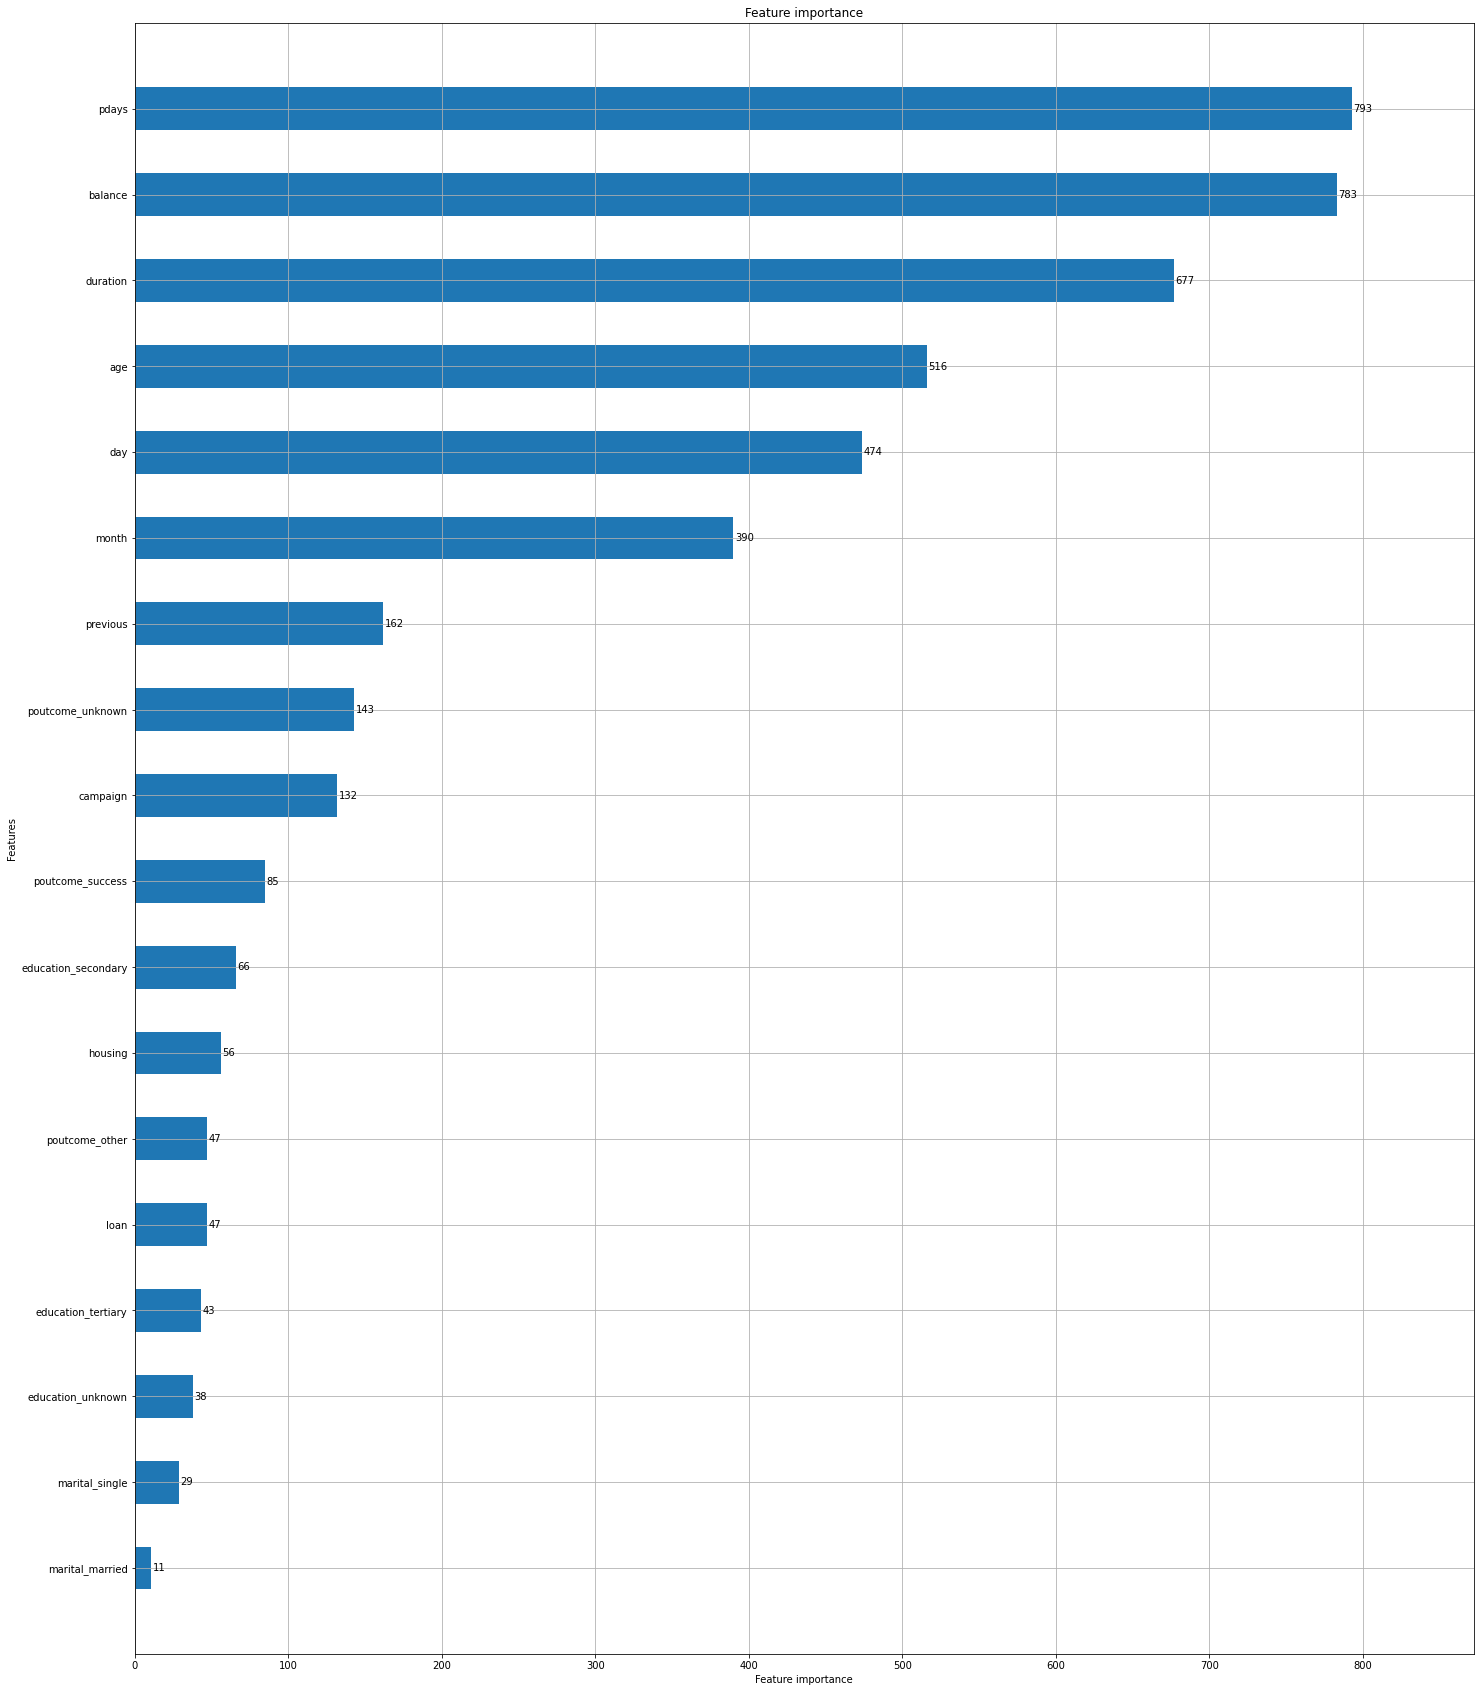

In [18]:
lgb.plot_importance(model, height=0.5, figsize=(24, 30))

0.8588992054219873


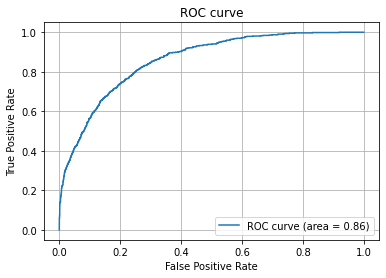

In [28]:
model.save_model('model.txt')

y_pred = model.predict(X_test, num_iteration=model.best_iteration)


len(y_test)

# AUC (Area Under the Curve) を計算する
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)


import matplotlib.pyplot as plt
%matplotlib inline
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

